In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import matplotlib.colors as colors
import scipy as sp
import numpy as np
import pickle as pickle
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
from IPython.display import display
%matplotlib inline
#%config InlineBackend.close_figures = False
from scipy.io.idl import readsav
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
#from pysynphot import observation
#from pysynphot import spectrum
import forwardmodel
import ciamod
import band
import TPmod
import cloud
import testkit

In [3]:
# start with the wavelength range
w1 = 1.0
w2 = 2.5


# How many patches & clouds do we want??
# Must be at least 1 of each, but can turn off cloud below
npatches = 1
nclouds = 1

# set up array for setting patchy cloud answers
do_clouds = np.zeros([npatches],dtype='i')

# Which patches are cloudy
do_clouds[:] = 0

# set up cloud detail arrays
cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudtype =np.zeros([npatches,nclouds],dtype='i')

# Now fill cloud details. What kind of clouds and shape are they?
# Cloud types
# 1:  slab cloud
# 2: deep thick cloud , we only see the top
# 3: slab with fixed thickness log dP = 0.005 (i.e. fits within a single layer)
# 4: deep thick cloud with fixed height (i.e. appears in a single layer)
# In both cases the cloud properties are density, rg, rsig for real clouds
# and dtau, w0, and power law for cloudnum = 89 or 99 for grey
cloudnum[:,0] = 99
cloudtype[:,0] = 1

#cloudnum[:,1] = 1
#cloudtype[:,1] = 2

#The cloud properties are set in cloudparams
cloudparams = np.zeros([5,npatches,nclouds],dtype='d')
# Cloud optical depth for types 1 or 3, numbers 89 and 99 (else this is density)
cloudparams[0,:,0] =  0.000001
# cloud top for all types (log P (bar))
cloudparams[1,:,0] = 0.0
# cloud height (dlog P)
cloudparams[2,:,0] = 0.005
# cloud single scattering albedo / a for hansen distribution
cloudparams[3,:,0] = 0.5
# optical depth index for non-grey cloud (cloud number = 89) / b for hansen distribution
cloudparams[4,:,0] = -2.0

# Cloud optical depth for types 1 or 3, numbers 89 and 99 (else this is density)
#cloudparams[0,:,1] = 1.0
# cloud top for all types (log P (bar))
#cloudparams[1,:,1] = 0.5
#cloud height (dlog P)
#cloudparams[2,:,1] = 0.005
# cloud single scattering albedo / a for hansen distribution
#cloudparams[3,:,1] = 0.
# optical depth index for non-grey cloud (cloud number = 89) / b for hansen distribution
#cloudparams[4,:,1] = 0.1


#What's the cloud covering fraction?
pcover = np.empty(npatches)
pcover[:] = 1.0

# gravity??
logg = 4.76

# distance (parsecs)
dist = 5.85

# scale factor r2d2 from distance 1 Rj radius
r2d2 = (71492e3)**2. / (dist * 3.086e+16)**2.

# Are we doing H- bound-free, free-free continuum opacities?
# (Is the profile going above approx 2000K in the photosphere?)
do_bff = 0

# are we doing chemical equilibrium?
chemeq = 0

# Set the profile type. If we're using a fixed one. Give the file name
proftype = 9
pfile = "t750g1000nc_m0.0.cmp"


# set up pressure grids in bar cos its intuitive
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
logfinePress = np.arange(-4.0, 2.4, 0.1)
# forward model wants pressure in bar
#logcoarsePress = np.arange(-4.0, 3.0, 0.5)
coarsePress = pow(10,logcoarsePress)
press = pow(10,logfinePress)
nlayers = press.size

# Where are the cross sections?
# give the full path
xpath = "../Linelists/"

# now the cross sections

# Now list the gases.
# If Na is after K, at the end of the list, alkalis will be tied
# together at Asplund solar ratio. See Line at al (2015)
# Else if K is after Na, they'll be separate

gaslist = ['h2o','ch4','nh3','K','Na']
invmr = np.array([-3.57,-3.44,-4.82,-5.60])
ngas = len(gaslist)

# some switches for alternative cross sections
# Use Mike's Alkalis?
#malk = 0


In [4]:
print(cloudparams)

[[[  1.00000000e-06]]

 [[  0.00000000e+00]]

 [[  5.00000000e-03]]

 [[  5.00000000e-01]]

 [[ -2.00000000e+00]]]


In [5]:
prof = np.full(13,100.)
if (proftype == 9):
    modP,modT = np.loadtxt(pfile,skiprows=1,usecols=(1,2),unpack=True)
    tfit = InterpolatedUnivariateSpline(np.log10(modP),modT,k=1)
    prof = tfit(logcoarsePress)

print(prof)

[  238.96758349   248.6733725    268.69805132   295.69693619   329.91086657
   373.95636669   441.11717167   559.25302134   743.9743596   1006.64037421
  1375.446243    1781.84676188  2425.61710913]


In [6]:
# set the profile
#prof = np.full(13,1700.)
temp = TPmod.set_prof(proftype,coarsePress,press,prof)


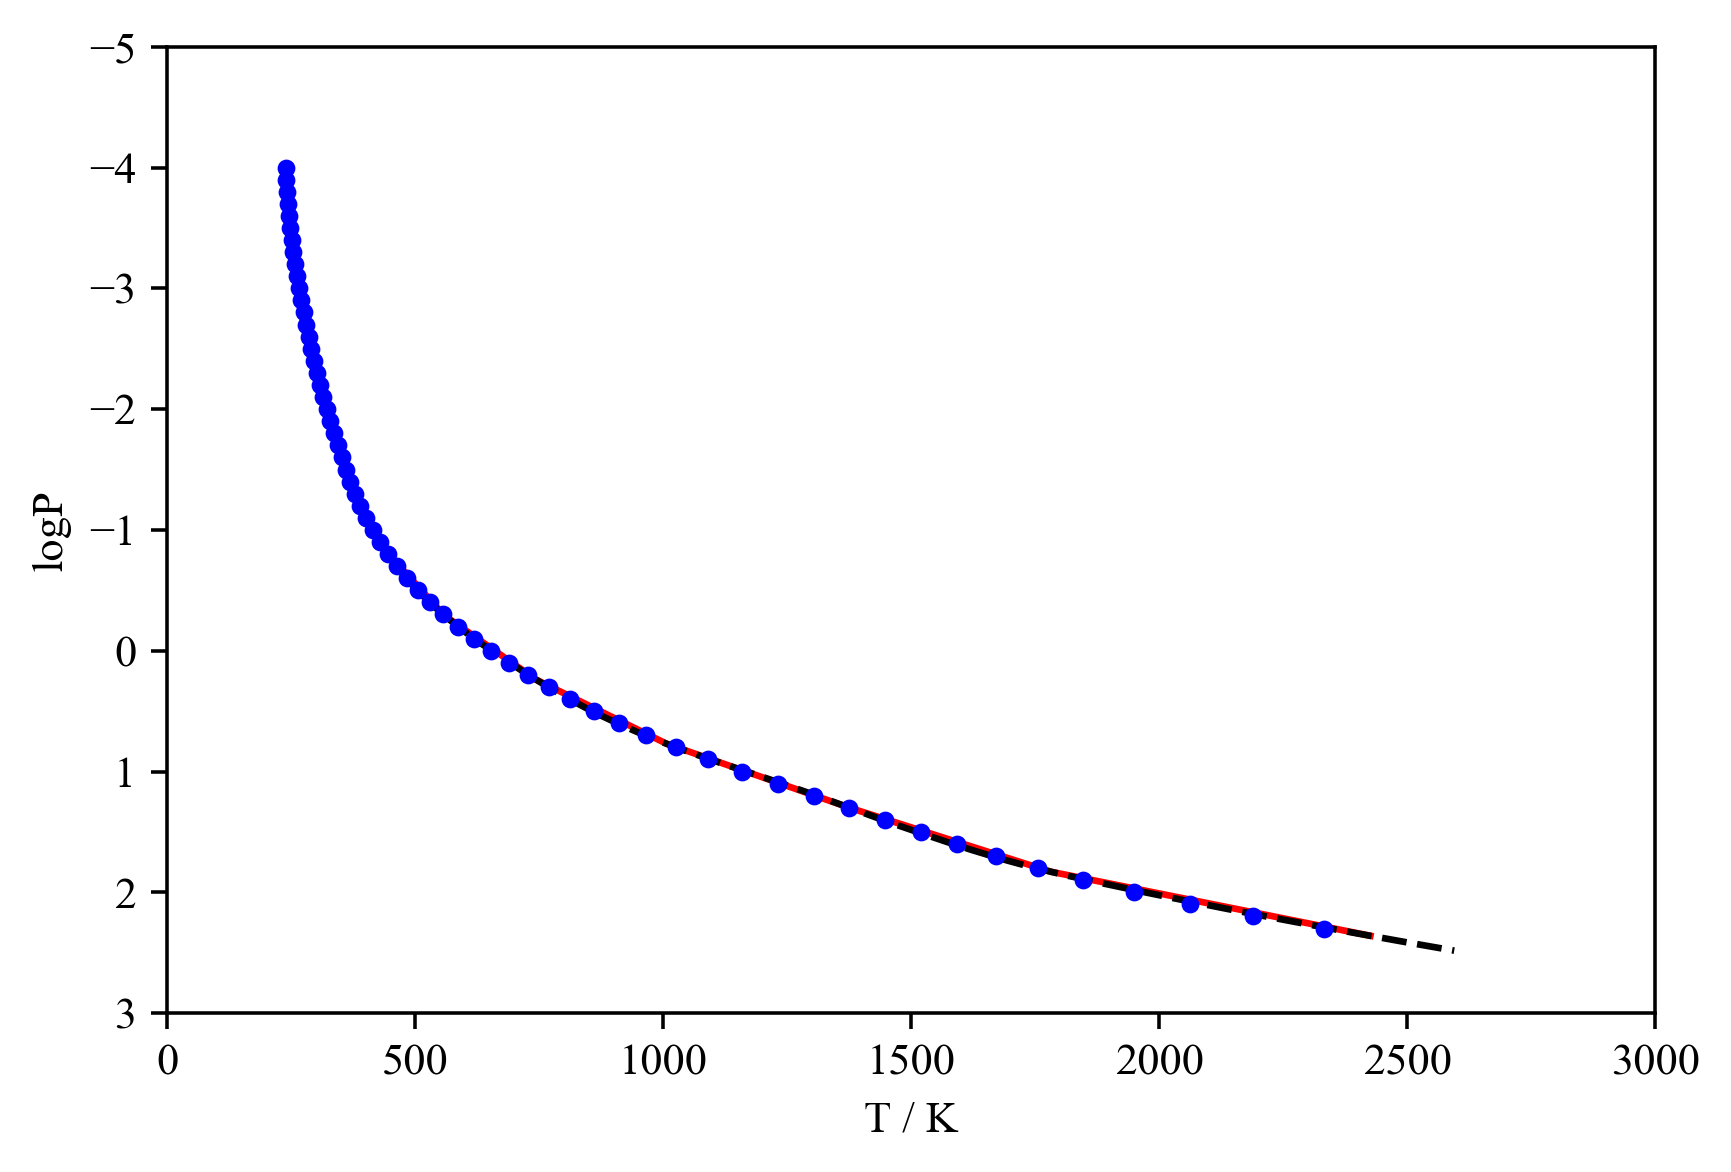

In [7]:
#Tparams = np.array([(0.24961265545013805, 0.29669980226249115, 0.34692402859455584), (0.12282222259062406, 0.15644945610649619, 0.19064094208914834), (-0.229568251913775, 0.16503714060561048, 0.68457833601497942), (3.0008442555754247, 4.1381930691794269, 4.7579819209736272), (4157.089778959039, 4851.2685890221546, 5767.5971072676621)])
#temp = TPmod.set_prof(2,coarsePress,finePress,Tparams[:,1])
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.,3000.,3.0,-5.0])
#plt.plot(miketemp,np.log10(mikepress),'r-')
#plt.plot(temp,np.log10(finePress),'b--')

plt.plot(prof,logcoarsePress,'r-')
plt.plot(modT,np.log10(modP),'k--')
plt.plot(temp,logfinePress,'b.')
plt.ylabel(r'logP')
plt.xlabel('T / K')

#

In [8]:
# now need to translate cloudparams in to cloud profile even
# if do_clouds is zero..

cloudprof,cloudrad,cloudsig = cloud.atlas(do_clouds,cloudnum,cloudtype,cloudparams,press)

cloudprof = np.asfortranarray(cloudprof,dtype = 'float64')
cloudrad = np.asfortranarray(cloudrad,dtype = 'float64')
cloudsig = np.asfortranarray(cloudsig,dtype = 'float64')
pcover = np.asfortranarray(pcover,dtype = 'float32')
cloudnum = np.asfortranarray(cloudnum,dtype='i')
do_clouds = np.asfortranarray(do_clouds,dtype = 'i')

In [9]:
#print(cloudprof)
#print(np.sum(cloudprof))

In [10]:
inlinetemps,inwavenum,linelist,gasnum,nwave = testkit.get_opacities(gaslist,w1,w2,press,xpath)

bff_raw,ceTgrid,metscale,coscale,gases_myP = testkit.sort_bff_and_CE(chemeq,"chem_eq_tables_P3K.pic",press,gaslist)

# Get the cia bits
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat", inwavenum)
cia = np.asfortranarray(np.empty((4, ciatemps.size, nwave)), dtype='float32')
cia[:, :, :] = tmpcia[:, :, :nwave]
ciatemps = np.asfortranarray(ciatemps, dtype='float32')


In [11]:
logVMR = np.empty((ngas,nlayers),dtype='d')
if chemeq == 1:
    # this case is a profile
    ng = invmr.shape[2]
    ngas = ng - 3
    logVMR = np.zeros([ngas,nlayers],dtype='d')
    for p in range(0,nlayers):
        for g in range(0,ng):
            tfit = InterpolatedUnivariateSpline(ceTgrid,invmr[:,p,g])
            if (g < 3):
                bff[g,p] = tfit(temp[p])
            else:
                logVMR[g-3,p]= tfit(temp[p])
elif (gasnum[gasnum.size-1] == 21):
    tmpvmr = np.empty(ngas,dtype='d')
    alkratio = 16.2 # from asplund et al (2009)
    tmpvmr[0:(ngas-2)] = invmr[0:(ngas-2)]
    tmpvmr[ngas-2] = np.log10(10.**invmr[ngas-2] / (alkratio+1.)) # K
    tmpvmr[ngas-1] = np.log10(10.**invmr[ngas-2] * (alkratio / (alkratio+1.)))
        
    for i in range(0,ngas):                              
        logVMR[i,:] = tmpvmr[i]
else:
    for i in range(0,ngas):                              
        logVMR[i,:] = invmr[i]

In [12]:
#print(logVMR)

In [13]:
bff = np.zeros([3,nlayers],dtype="float64")
# Now get the BFF stuff sorted
if (chemeq == 0 and do_bff == 1):
    for gas in range(0,3):
        for i in range(0,nlayers):
            tfit = InterpolatedUnivariateSpline(ceTgrid,bff_raw[:,i,gas],k=1) 
            bff[gas,i] = tfit(temp[i])
print(bff.shape)
bff = np.asfortranarray(bff, dtype='float64')


(3, 64)


In [14]:
press = np.asfortranarray(press,dtype='float32')
temp = np.asfortranarray(temp,dtype='float64')
logVMR = np.asfortranarray(logVMR,dtype='float64')


In [15]:
print(forwardmodel.marv.__doc__)

outspec,cl_phot_press,oth_phot_press,cfunc = marv(temp,logg,r2d2,ingasnum,logvmr,pcover,do_clouds,incloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,inpress,inwavenum,inlinelist,cia,ciatemps,use_disort,make_cl_pspec,make_oth_pspec,make_cf,do_bff,bff)

Wrapper for ``marv``.

Parameters
----------
temp : in/output rank-1 array('d') with bounds (f2py_temp_d0)
logg : input float
r2d2 : input float
ingasnum : in/output rank-1 array('i') with bounds (f2py_ingasnum_d0)
logvmr : in/output rank-2 array('d') with bounds (f2py_logvmr_d0,f2py_logvmr_d1)
pcover : in/output rank-1 array('f') with bounds (f2py_pcover_d0)
do_clouds : in/output rank-1 array('i') with bounds (f2py_do_clouds_d0)
incloudnum : in/output rank-2 array('i') with bounds (f2py_incloudnum_d0,f2py_incloudnum_d1)
cloudrad : in/output rank-3 array('d') with bounds (f2py_cloudrad_d0,f2py_cloudrad_d1,f2py_cloudrad_d2)
cloudsig : in/output rank-3 array('d') with bounds (f2py_cloudsig_d0,f2py_cloudsig_d1,f2py_cloudsig_d2)
cloudprof : i

In [16]:
# switches for tau spec, phot spec and contribution function
ophot = 0
clphot = 0
make_cf = 0
# other switches; ignore
use_disort = 0
# now we can call the forward model
tmpoutspec,tmpclphotspec,tmpophotspec,cf = forwardmodel.marv(temp,logg,r2d2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps,use_disort,clphot,ophot,make_cf,do_bff,bff)

# This bit trims off the unused portion of the array
outspec = np.zeros((2,nwave),dtype='d')
outspec[:,:] = tmpoutspec[:,:nwave]

In [17]:
# check some values
print(outspec)

[[  2.49986379e+00   2.49961383e+00   2.49936389e+00 ...,   1.00028208e+00
    1.00018207e+00   1.00008206e+00]
 [  1.68712931e-16   9.90795271e-17   1.48468898e-16 ...,   1.00536834e-15
    9.98986299e-16   9.72537860e-16]]


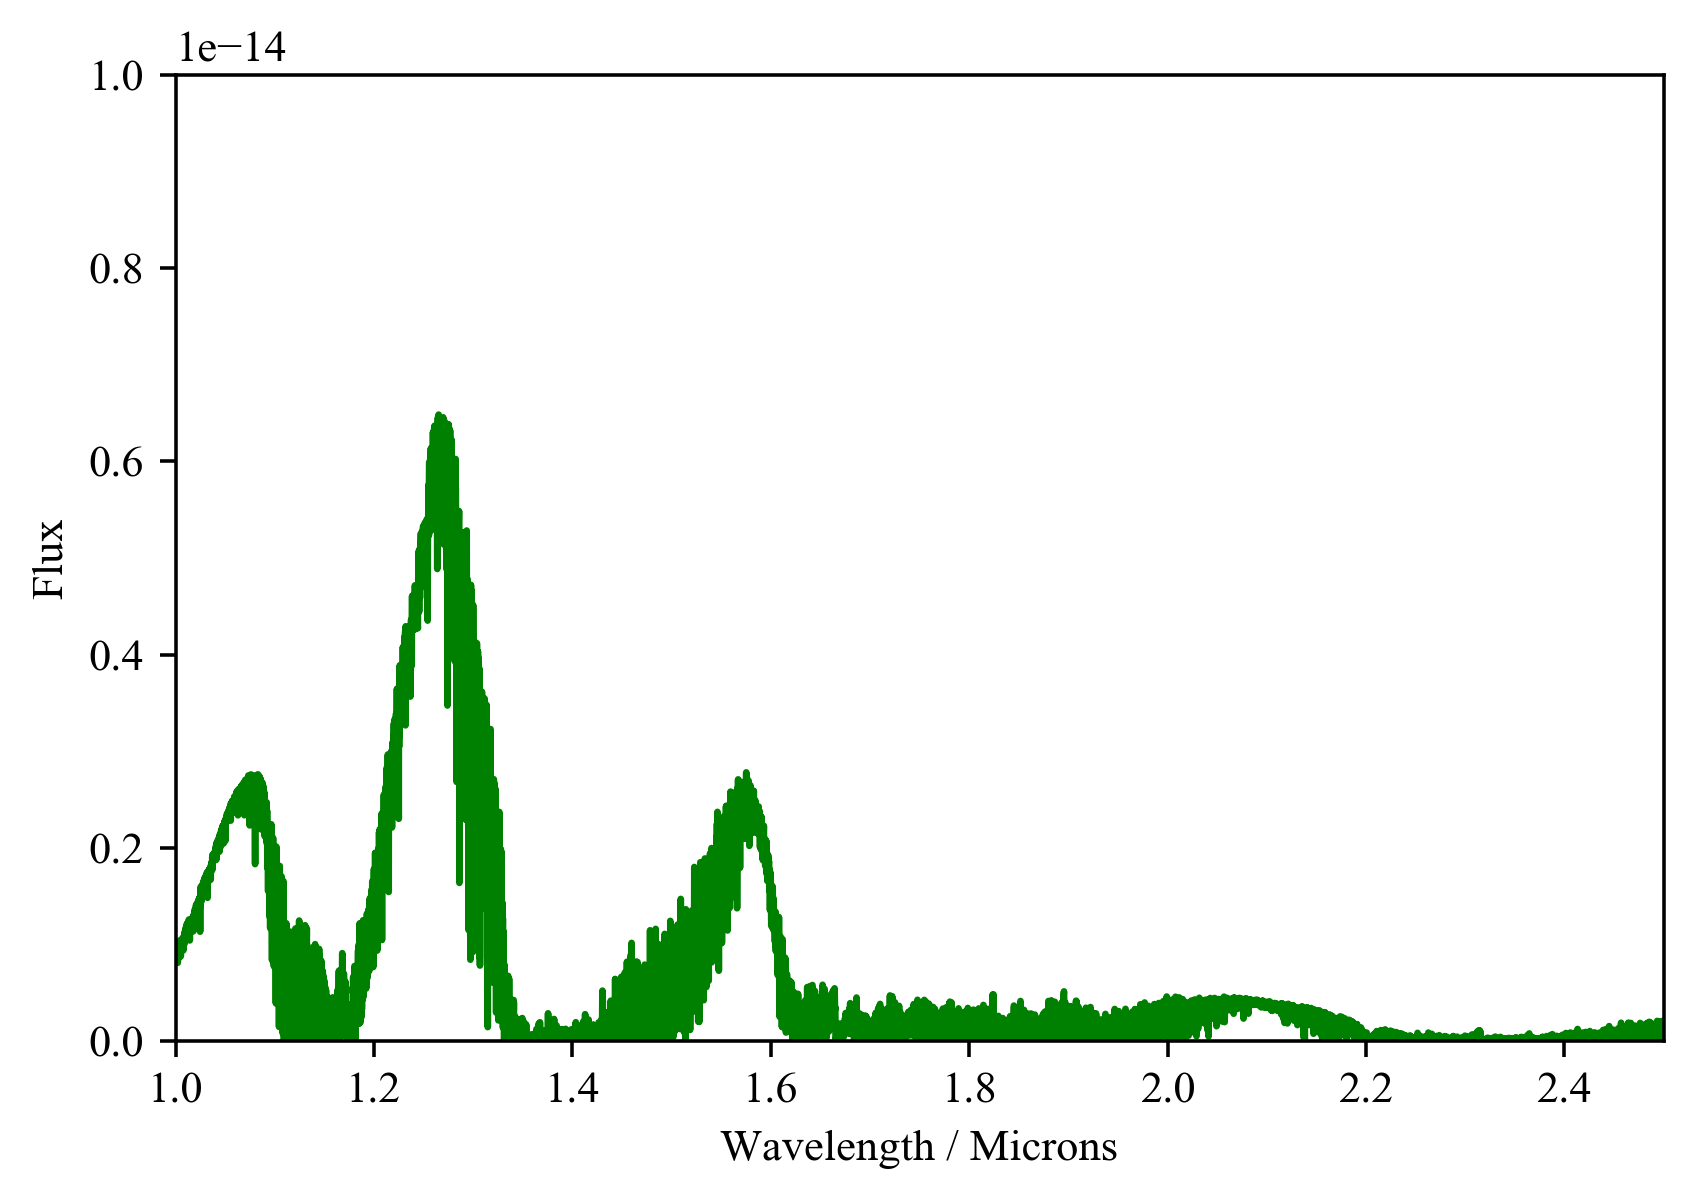

In [18]:
# plot the spectrum to have a look at it
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([1., 2.5,0.,1e-14])

#ax = fig.add_subplot(1,1,1)

#ax.set_yscale('log')
#ax.set_xscale('log')

plt.plot(outspec[0,:],outspec[1,:],'g-')
#plt.plot(outspec_c[0,:],outspec_c[1,:],'r-')

#plt.plot(outspec[0,:],(1.+ ((outspec[1,:]- oldspec[1,:])/outspec[1,:]))*1e5,'g-')

#plt.plot(mikespec[0,:],outspec[1,:] / (mikespec[1,:]/1e6),'r-')
#plt.plot(mikespec[0,:],((mikespec[1,:] / 1e6) / outspec[1,:]), 'r-')
#plt.plot(outspec[0,:],np.full(nwave,1.0),'b--')

#plt.plot(outspec[0,:],6.666*outspec[1,:],'b-')
plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
#plt.savefig('testspec.pdf',format='pdf', dpi=720)

In [19]:
# get the observed spectrum
obspec = np.asfortranarray(np.loadtxt("G570D_2MassJcalib.dat",dtype='d',unpack='true'))

In [20]:
# This bit convolves the spectrum with a gaussian
wlen = outspec.shape[1]
wint = outspec[0,0] - outspec[0,wlen-1]
disp = wint / wlen
fwhm = 0.005
gwidth = int((((fwhm / disp) // 2) * 2) +1)

# now get the kernel and convolve
gauss = Gaussian1DKernel(gwidth)
cspec = convolve(outspec[1,:],gauss,boundary='extend')
modspec = np.array([outspec[0,::-1],cspec[::-1]])
    
# rebin to observed dispersion
#wfit = sp.interpolate.splrep(spec[0,:],spec[1,:],s=0)
#modspec = sp.interpolate.splev(obspec[0,:],wfit,der=0)
    

In [21]:
#s2 = obspec[2,::3]**2 
#lnLik=-0.5*np.sum((((obspec[1,::3] - modspec[::3])**2) / s2) + np.log(2.*np.pi*s2))
#print(lnLik)

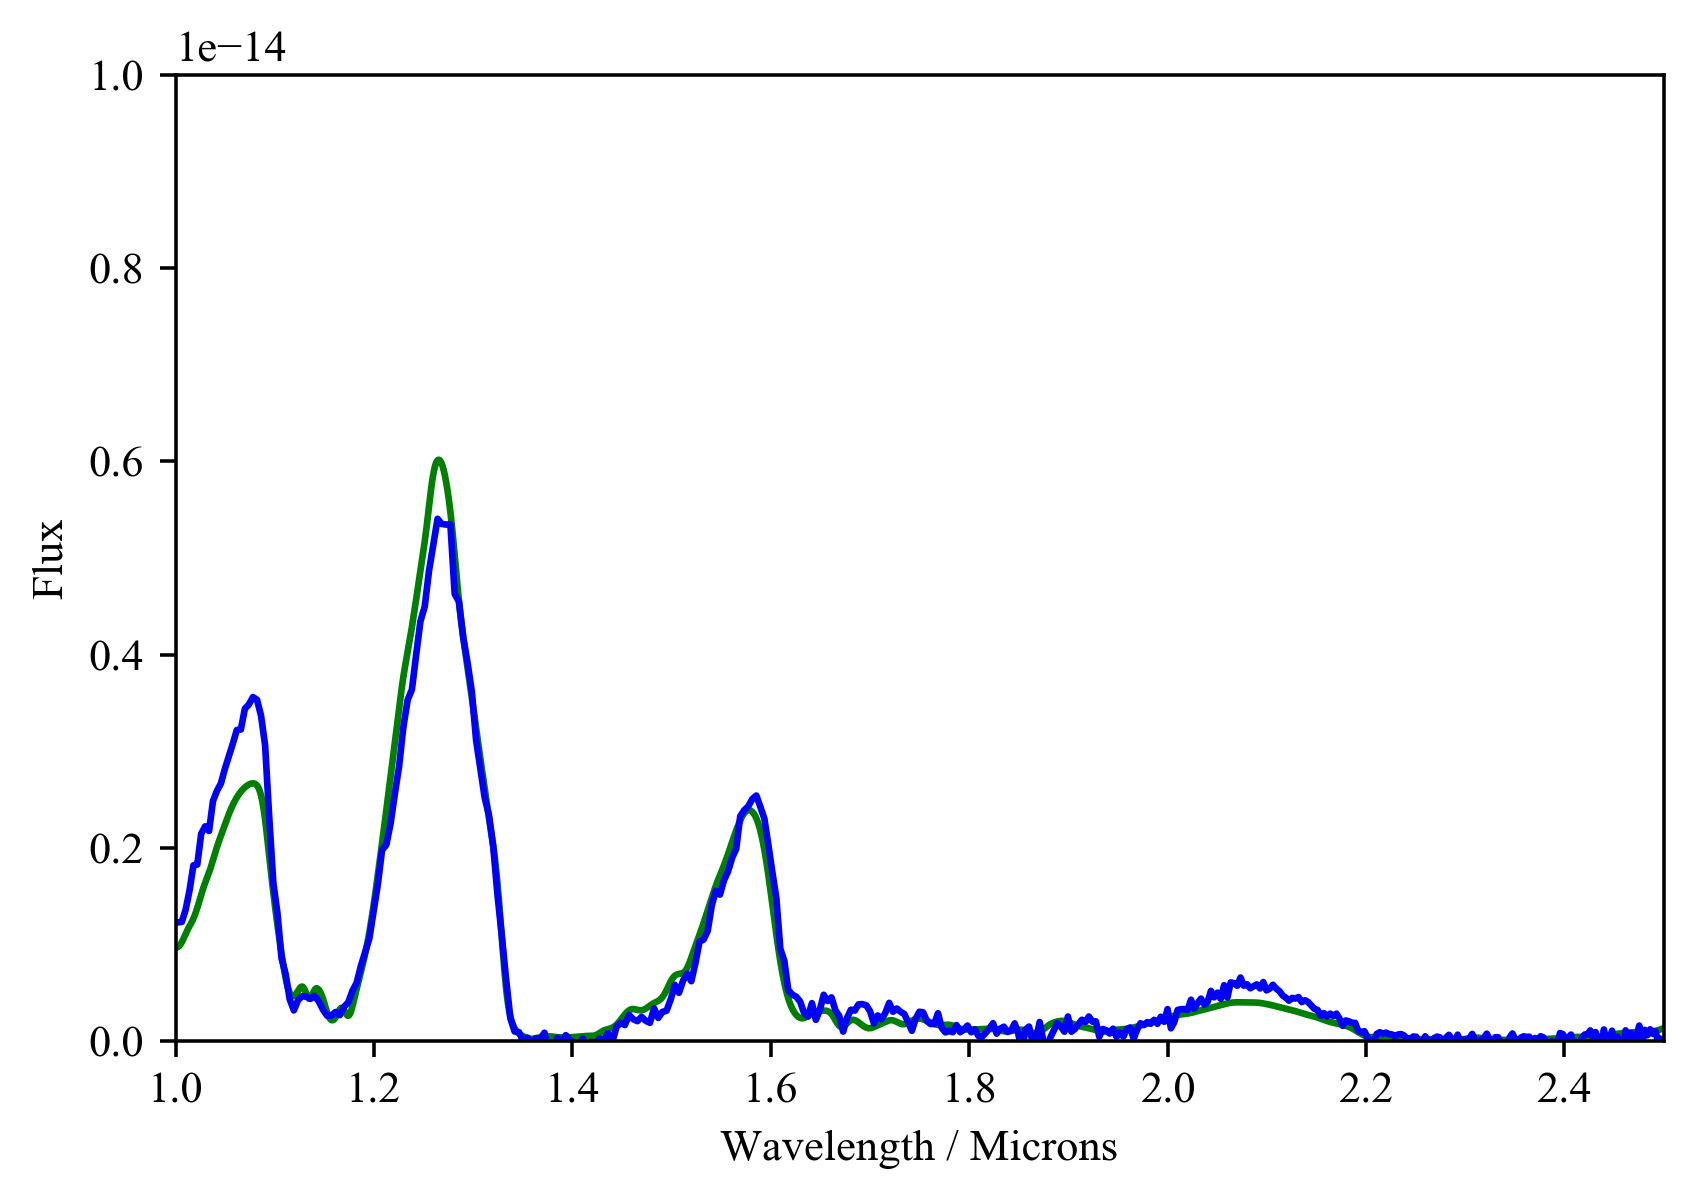

In [22]:
# plot the spectrum to have a look at it
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([1.0, 2.5,0.,1e-14])

ax = fig.add_subplot(1,1,1)

#ax.set_yscale('log')
#ax.set_xscale('log')

plt.plot(modspec[0,:],modspec[1,:],'g-')
plt.plot(obspec[0,:],obspec[1,:],'b-')


plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
#plt.savefig('testspec.pdf',format='pdf', dpi=720)

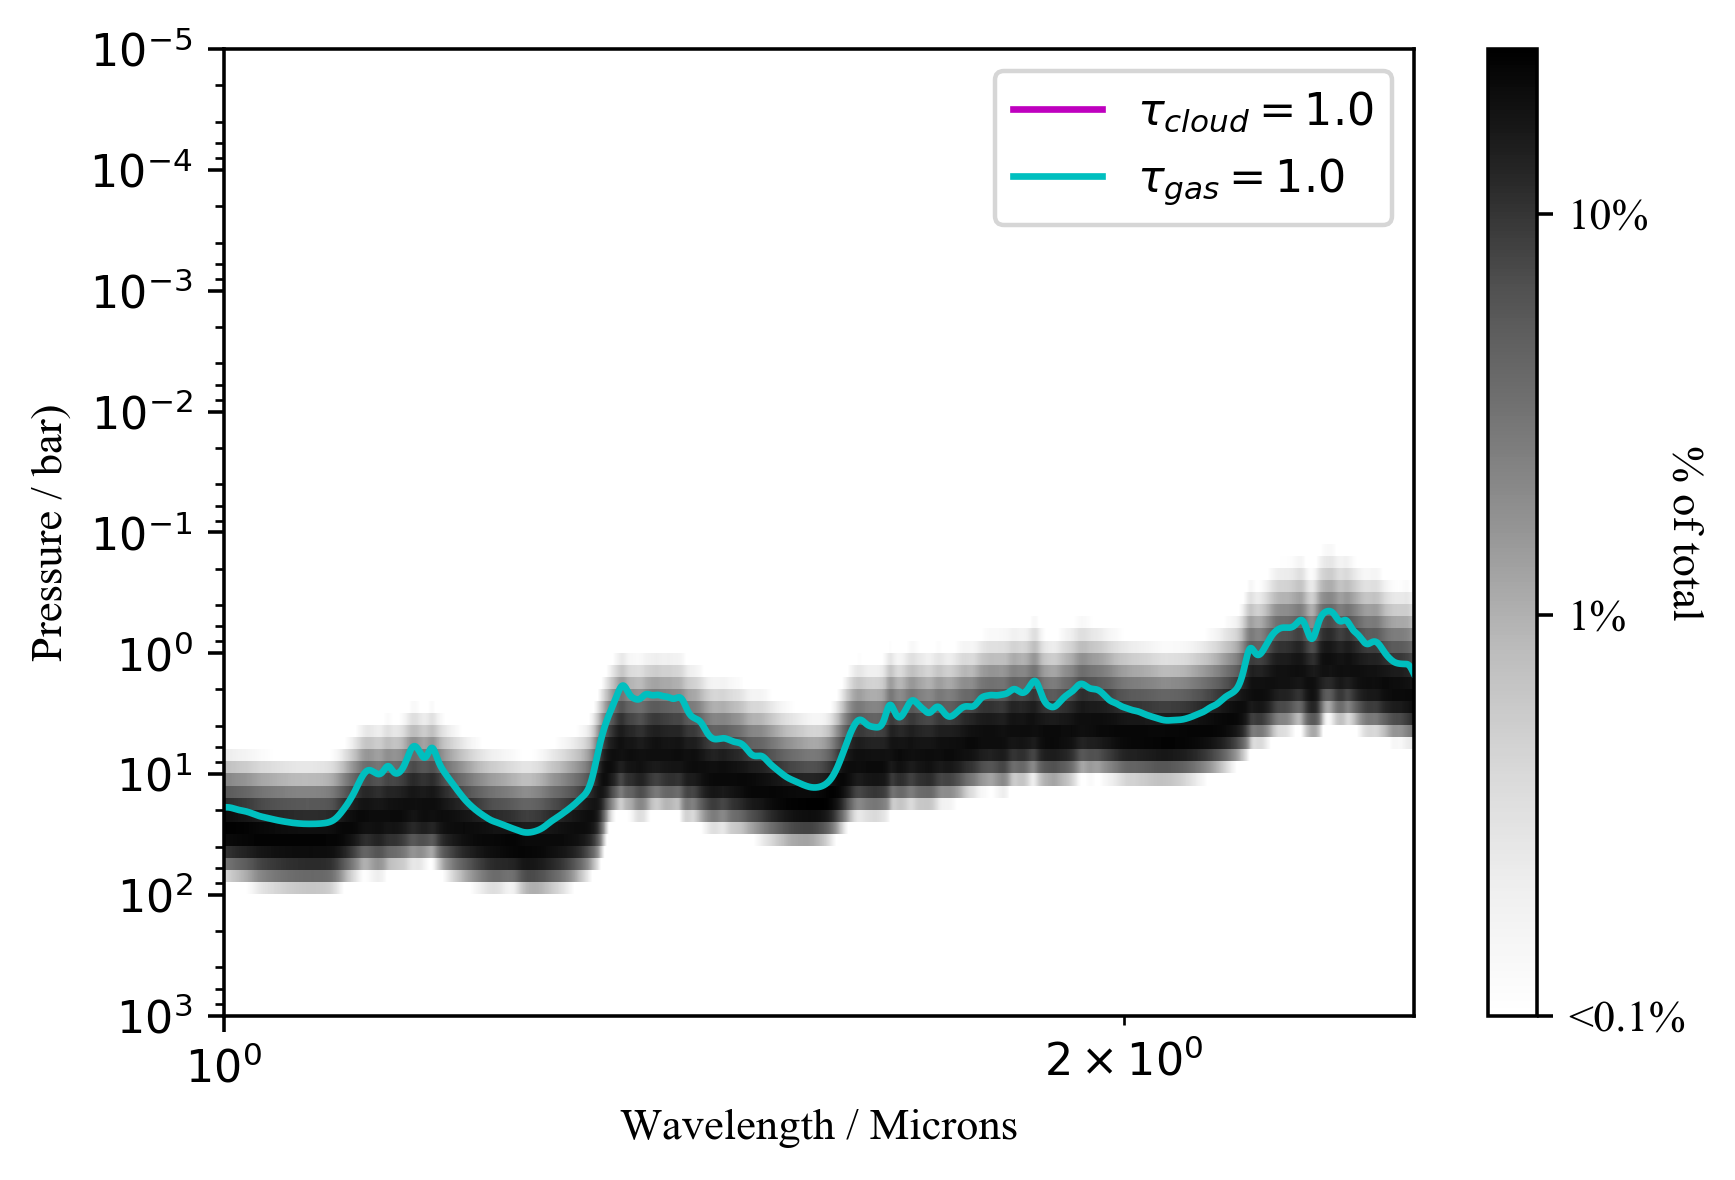

In [23]:
ophot = 1
clphot = 1
make_cf = 1
# other switches; ignore
use_disort = 0
# now we can call the forward model
tmpoutspec,tmpclphotspec,tmpophotspec,cf = forwardmodel.marv(temp,logg,r2d2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps,use_disort,clphot,ophot,make_cf,do_bff,bff)

clphotspec = tmpclphotspec[0:npatches,:nwave].reshape(npatches,nwave)
ophotspec = tmpophotspec[0:npatches,:nwave].reshape(npatches,nwave)
cfunc = np.zeros([npatches,nwave,nlayers],dtype='d')
cfunc = cf[:npatches,:nwave,:nlayers].reshape(npatches,nwave,nlayers)


nwave = inwavenum.size
cfunc = np.reshape(cfunc,[cfunc.shape[1],cfunc.shape[2]])
fwhm = 0.005
wlen = outspec.shape[1]
wint =  outspec[0,0] - outspec[0,wlen-1]
# convolve with instrumental profile
# start by setting up kernel
# First step is finding the array index length of the FWHM
disp = wint / wlen
gwidth = int((((fwhm / disp) // 2) * 2) +1)
# needs to be odd
# now get the kernel and convolve
gauss = Gaussian1DKernel(gwidth)

for ilayer in range (0,press.size):
    cfunc[:,ilayer] = convolve(cfunc[:,ilayer],gauss,boundary='extend')

tau1_cl_Press = convolve(clphotspec[0],gauss,boundary='extend')[::-1]
tau1_oth_Press = convolve(ophotspec[0],gauss,boundary='extend')[::-1]
    
wavenew = outspec[0,::-1]
press = press.reshape(64,)
normfunc = np.zeros_like(cfunc)
for iwave in range(0,nwave):
    totcont = np.sum(cfunc[iwave,:])
    normfunc[iwave,:] = cfunc[iwave,:] / totcont

plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=120)
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([1.0,2.5,1000,1e-5])

ax = fig.add_subplot(1,1,1)

ax.set_yscale('log')
ax.set_xscale('log')
#major_ticks = np.arange(1.0,15.,1.0)
#minor_ticks = np.arange(1.0,15.,0.5)
#ax.set_xticks(major_ticks)                                                       
#ax.set_xticks(minor_ticks, minor=True)                                           

plt.pcolormesh(wavenew,press,(normfunc[::-1,:].transpose()),cmap='Greys',norm=colors.SymLogNorm(linthresh=0.001,linscale=0.00001,
                                              vmin=0., vmax=np.amax(normfunc)))

t1, = plt.plot(wavenew,(tau1_cl_Press),'m-',label=r'$\tau_{cloud} = 1.0$')
t2, = plt.plot(wavenew,(tau1_oth_Press),'c-', label =r'$\tau_{gas} = 1.0$')

plt.legend(handles=[t1,t2])


cbar = plt.colorbar(orientation='vertical',norm=colors.Normalize(clip=False),ticks=[1e-3,1e-2,0.1])
cbar.ax.set_yticklabels(['<0.1%', '1%', '10%'])
cbar.set_label('% of total', rotation=270)
plt.ylabel("Pressure / bar)")
plt.xlabel('Wavelength / Microns')
#plt.savefig(runname+'_contribution.png',format='png', dpi=120)